**$T_1.$** Soit $X_1$, ..., $X_n$ des variables aléatoires iid de loi $\mathcal{N}(\theta, 1)$, où $\theta$ est inconnu.
1.  (a) Montrer que $\widehat{\theta_n} = \frac{1}{n} \sum\limits_{k=1}^{n}X_k$ converge presque sûrement vers $\theta$.
    
    (b) Déterminer la loi de $\sqrt{n}(\widehat{\theta_n} - \theta)$.
1. Soit $\alpha$ $\in$ $]0, \;1[$ fixé et $\Phi$ la fonction répartition de la loi Gaussienne $\mathcal{N}(\theta, 1)$. Déterminer en fonction de $\alpha$, de $n$, de $\Phi^{-1}$ et de $\theta_0$ la valeur optimale de $K_\alpha$ pour que la relation $\mathbb{P}_{\theta = \theta_0}(T_K=1) \leq \alpha$ soit satisfaite avec une égalité.


//TODO T1 1.a, 1.b, 2

**$S_1.$** Créer un code python permettant:
1. de simuler $n$ variables gaussiennes indépendantes de loi $\mathcal{N}(\theta_0, 1)$,
1. de calculer pour $\alpha$ et $\theta_0$ fixés, la constante $K_\alpha$ et qui vous renvoie la valeur optimale de votre règle
de décision.
1. Pour $\theta_0 = 3$, $\alpha = 0.05$ et $n = 100$ répéter $N = 100$ fois l’expérience et compter le nombre fois où
vous avez décidé $H_0$. On appelle ce nombre $N_n$ quelle est sa loi?
1. Pour $n \in \{100,\; 1000\}$ et $N \in \{100, 1000, 5000\}$, Simuler $500$ valeurs de la variable aléatoire $N_n$ et
les représenter sous forme d’histogramme. Que remarquez-vous?

In [175]:
# Imports
import math
from typing import List

import numpy as np
from scipy.special import erfinv
from scipy.stats import binom
import matplotlib.pyplot as plt

In [176]:
# S1.1
def n_gauss_iid(theta0: float, n: int) -> np.ndarray:
    """Generates n independent gaussian random variables of standard deviation 1 and average theta0.

    Args:
        theta0 (float): average value
        n (int): number of random variables to generate.
    Returns:
        np.ndarray: array with sample of n independent gaussian random variables.
    """
    sigma = 1
    return np.random.normal(theta0, sigma, n)

In [177]:
# S1.2
def phi_inv(p: float) -> float:
    """Quantile function (inverse of the cumulative function) of the standard normal distribution.

    Args:
        p (float): probability (p in ]0, 1[)

    Returns:
        float: x which phi(x) = p
    """
    return math.sqrt(2.)*erfinv(2.*p - 1.)

def get_k_alpha(theta0: float, alpha: float, n: int) -> float:
    """Calculates the optimal alpha for a decision with probability alpha of false negatives.

    Args:
        theta0 (float): average value
        alpha (float): upper limit of probability of chosing H1 given that H0 is true (false negative)
        n (int): sample size

    Returns:
        float: optimal value K alpha
    """
    return phi_inv(alpha)/math.sqrt(n) + theta0

In [178]:
# S1.3

def theta_estimator(x: np.ndarray) -> float:
    """Estimator for theta

    Args:
        x (np.ndarray): independant samples of random variable

    Returns:
        float: estimated theta value
    """    
    return x.mean()

def decision_rule(x: np.ndarray, k: float) -> bool:
    """Outputs the decision. 0 if H0 and 1 if H1 are chosen

    Args:
        x (np.ndarray): samples of random variable
        k (float): decision threshold

    Returns:
        bool: decision result (True = H1, False = H0)
    """    
    return theta_estimator(x) < k

def simulate_Nn(theta0: float, alpha: float, n: int, N: int) -> int:
    """Simulates Nn, the count of the times H0 is decided
    **It follows a Binomial distribution ~ B(N, 1 - alpha)**
    Because we have a binary choice of deciding H0 or not with a probability of 1 - alpha
    Each trial follows a Bernoulli distribution of p = 1 - alpha and is independent
    Therefore the sum follows a Binomial distribution

    Args:
        theta0 (float): average value
        alpha (float): false negative probability
        n (int): number of samples of each trial
        N (int): number of trials

    Returns:
        int: count of how many times H0 was decided
    """    
    k_alpha = get_k_alpha(theta0, alpha, n)
    return N - sum(decision_rule(n_gauss_iid(theta0, n), k_alpha) for _ in range(N))



In [179]:
theta0 = 3.
alpha = 0.05
n = 100
N = 100

simulate_Nn(theta0, alpha, n, N)

94

In [184]:
# S1.4
def binomial_dist_pmf(n_trials: int, prob: float, start: int=0, end:int= None, scale: float=1.) -> tuple[np.ndarray, np.ndarray]:
    """Calculates the x and y axis of the probability mass function of a binomial distribution

    Args:
        n_trials (int): number of trials
        prob (float): probability of Bernoulli
        start (int, optional): Start of x axis. Defaults to 0.
        end (int, optional): End of x axis. None means n_trials. Defaults to None.
        scale (float, optional): Scaling factor. Defaults to 1..

    Returns:
        Tuple[np.ndarray, np.ndarray]: x and y axis of the probability mass function
    """    
    if end is None:
        end = n_trials
    x = np.array(range(start, end + 1))
    
    y = scale*binom.pmf(x, n_trials, prob)
    return x, y


def plot_Nn(Ns: List[int], ns: List[int], theta0: float, alpha: float, num_values: int, plot_width: float) -> None:
    """Plots the simulation of the histogram Nn

    Args:
        Ns (List[int]): List of number of trials
        ns (List[int]): List of number of samples of each trial
        theta0 (float): average value
        alpha (float): false negative probability
        num_values (int): Number of values of Nn sampled for each case
        plot_width (float): Plot width in inches
    """    
    fig, axs = plt.subplots(len(ns), len(Ns))
    fig.suptitle("Distribution of $N_n$", size=20)
    fig.tight_layout()
    fig.set_size_inches(plot_width, plot_width*len(ns)/len(Ns))

    for i, n in enumerate(ns):
        for j, N in enumerate(Ns):
            test = [simulate_Nn(theta0, alpha, n, N) for _ in range(num_values)]
            Nn_min = min(test)
            Nn_max = max(test)
            counts, bins = np.histogram(test, bins=Nn_max - Nn_min + 1)
            axs[i, j].stairs(counts, bins, fill=True, label="simulation", color="navy")
            axs[i, j].plot(
                *binomial_dist_pmf(N, 1. - alpha, Nn_min, Nn_max, num_values),
                label="theory", color="crimson", linestyle="dashed", linewidth=3
            )
            axs[i, j].set_title(f"n = {n}, N = {N}")
            axs[i, j].legend(loc="upper left")

    plt.show()

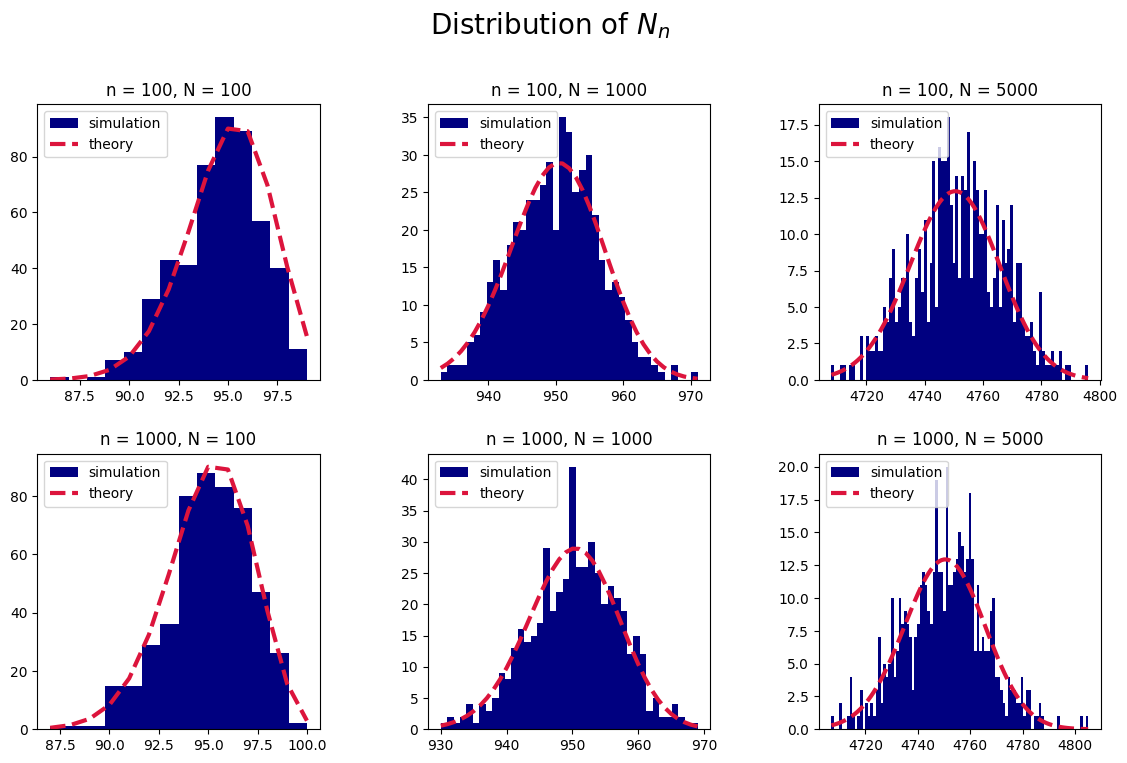

In [185]:
theta0 = 3.
alpha = 0.05
ns = [100, 1000]
Ns = [100, 1000, 5000]
num_values = 500
plot_width = 12

plot_Nn(Ns, ns, theta0, alpha, num_values, plot_width)

# The distribution of Nn closely matches our predicted Binomial distribuition in all cases
# In general, increasing n seems to slightly reduce the noise of the data and makes it follow the theorical curve more closely
# Increasing N clearly makes the results more noisy as we don't increase the number of values of Nn accordingly
# and we kept each histogram bucket with a width of 1.